In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import os
import pickle as pkl
from collections.abc import MutableMapping
import time
from typing import Any, Callable, Iterable, Mapping, Optional, Union
import json

import matplotlib.pyplot as plt
import numpy as np
import tqdm

os.environ["CUDA_VISIBLE_DEVICES"] = "7"
os.environ["DDE_BACKEND"] = "jax"

import jax
from jax import vmap, lax
import jax.numpy as jnp
from jax.example_libraries import optimizers

import flax
from flax import linen as nn
import optax
from frozendict import frozendict

import jraph
from jraph._src import graph as gn_graph
from jraph._src import utils

print(f'Jax: CPUs={jax.local_device_count("cpu")} - GPUs={jax.local_device_count("gpu")}')

Jax: CPUs=1 - GPUs=1


In [3]:
from hgnn.model import *
from hgnn.hamiltonian import *
from hgnn.training import *
from hgnn.simulating import *

In [25]:
prefix = 'pendulum-n3'

Zs_train = jnp.load(f'./data/{prefix}/Zs_train.npy')
Zs_dot_train = jnp.load(f'./data/{prefix}/Zs_dot_train.npy')
Zs_test = jnp.load(f'./data/{prefix}/Zs_test.npy')
Zs_dot_test = jnp.load(f'./data/{prefix}/Zs_dot_test.npy')

N2, dim = Zs_train.shape[-2:]
N = N2 // 2
species = jnp.zeros(N, dtype=int)
masses = jnp.ones(N)

Zs = Zs_train.reshape(-1, N2, dim)
Zs_dot = Zs_dot_train.reshape(-1, N2, dim)

Zst = Zs_test.reshape(-1, N2, dim)
Zst_dot = Zs_dot_test.reshape(-1, N2, dim)

print('N2:', N2)
print('dim:', dim)
print('Zs.shape:', Zs.shape)
print('Zs_dot.shape:', Zs_dot.shape)
print('Zst.shape:', Zst.shape)
print('Zst_dot.shape:', Zst_dot.shape)
print('Zs_test.shape:', Zs_test.shape)
print()

with open(f'./data/{prefix}/param.json', 'r') as f:
    d = json.load(f)
    stride = d['stride']
    dt = d['dt']
    
print('stride:', stride)
print('dt:', dt)

N2: 6
dim: 2
Zs.shape: (7500, 6, 2)
Zs_dot.shape: (7500, 6, 2)
Zst.shape: (2500, 6, 2)
Zst_dot.shape: (2500, 6, 2)
Zs_test.shape: (25, 100, 6, 2)

stride: 1000
dt: 1e-05


In [11]:
def pendulum_connections(P):
    return (jnp.array([i for i in range(P-1)] + [i for i in range(1, P)], dtype=int),
            jnp.array([i for i in range(1, P)] + [i for i in range(P-1)], dtype=int))

def edge_order(P):
    N = (P-1)
    return jnp.array(jnp.hstack([jnp.array(range(N, 2*N)), jnp.array(range(N))]), dtype=int)

senders, receivers = pendulum_connections(N)
eorder = edge_order(N)

In [12]:
key = jax.random.PRNGKey(42)

Ef = 1  # eij dim
Oh = 1

Eei = 5
Nei = 5

hidden = 5
nhidden = 2

In [13]:
params = generate_HGNN_params(Oh, Nei, Ef, Eei, dim, hidden, nhidden, key)

In [14]:
R, V = jnp.split(Zs[0], 2, axis=0)

apply_fn = energy_fn(senders=senders, receivers=receivers, species=species, R=R, V=V, eorder=eorder)
Hmodel = generate_Hmodel(apply_fn)


def phi(x):
    X = jnp.vstack([x[:1, :]*0, x])
    return jnp.square(X[:-1, :] - X[1:, :]).sum(axis=1) - 1.0

constraints = get_constraints(N, dim, phi)

zdot_model, lamda_force_model = get_zdot_lambda(
    N, dim, hamiltonian=Hmodel, drag=None, 
    constraints=constraints, 
    external_force=None)


v_zdot_model = vmap(zdot_model, in_axes=(0, 0, None))

Training ...


/tmp/ipykernel_54326/4122033605.py:35: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for epoch in tqdm.tnrange(epochs):


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 50/2000 Loss (MSE):  train=5.105631351470947, test=22.589975357055664
Epoch: 100/2000 Loss (MSE):  train=0.0019023959757760167, test=0.0007206756272353232
Epoch: 150/2000 Loss (MSE):  train=2.92191489279503e-05, test=2.356639743084088e-05
Epoch: 200/2000 Loss (MSE):  train=0.0008474013884551823, test=0.004619003273546696
Epoch: 250/2000 Loss (MSE):  train=0.0007842393824830651, test=0.0011575802927836776
Epoch: 300/2000 Loss (MSE):  train=0.00037077549495734274, test=0.0004297311243135482
Epoch: 350/2000 Loss (MSE):  train=0.012249628081917763, test=0.006170636974275112
Epoch: 400/2000 Loss (MSE):  train=0.00013770400255452842, test=0.000781384005676955
Epoch: 450/2000 Loss (MSE):  train=4.3716339860111475e-05, test=0.00023212103405967355
Epoch: 500/2000 Loss (MSE):  train=0.004272743593901396, test=0.0005067817983217537
Epoch: 550/2000 Loss (MSE):  train=5.140547614246316e-07, test=3.2816903967614053e-06
Epoch: 600/2000 Loss (MSE):  train=1.9968518245150335e-05, test=0.00011106

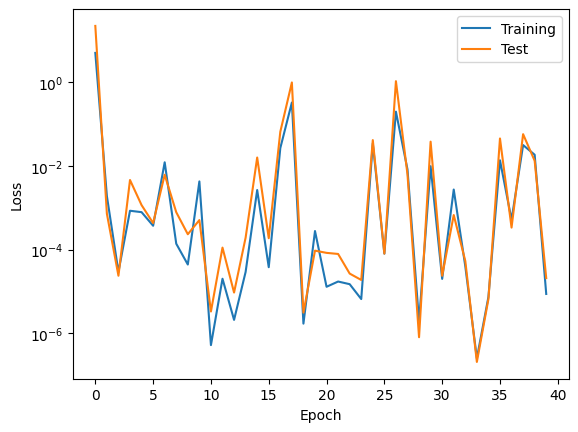

In [15]:
lr = 1e-2
batch_size = 100
epochs = 2000

loss_fn = generate_loss_fn(v_zdot_model=v_zdot_model)
gloss = generate_gloss(loss_fn=loss_fn)

opt_init, opt_update_, get_params = optimizers.adam(lr)

opt_update = generate_opt_update_wrapper(opt_update_=opt_update_)

step = generate_update_fn(gloss=gloss, opt_update=opt_update, get_params=get_params)

Rs, Vs = jnp.split(Zs, 2, axis=1)
Rst, Vst = jnp.split(Zst, 2, axis=1)

bRs, bVs, bZs_dot = batching(Rs, Vs, Zs_dot,
                            size=min(len(Rs), batch_size))

print(f"Training ...")

# opt_state = optimiser.init(params)
opt_state = opt_init(params)

epoch = 0
optimizer_step = -1
larray = []
ltarray = []

start = time.time()
train_time_arr = []

last_loss = 1000

for epoch in tqdm.tnrange(epochs):
    l = 0.0
    for data in zip(bRs, bVs, bZs_dot):
        optimizer_step += 1
        opt_state, params, l_ = step(optimizer_step, (opt_state, params, 0), *data)
        l += l_
    l = l/len(bRs)
    if (epoch + 1) % (epochs // 20) == 0:
        # opt_state, params, l = step(
        #     optimizer_step, (opt_state, params, 0), Rs, Vs, Zs_dot)
        larray += [l]
        ltarray += [loss_fn(params, Rst, Vst, Zst_dot)]
        print(f"Epoch: {epoch + 1}/{epochs} Loss (MSE):  train={larray[-1]}, test={ltarray[-1]}")

    now = time.time()
    train_time_arr.append((now - start))
    
params = get_params(opt_state)

fig, axs = plt.subplots(1, 1)
plt.semilogy(larray, label="Training")
plt.semilogy(ltarray, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [20]:
runs = Zs_test.shape[1]
maxtraj = Zs_test.shape[0]

sim_model = get_forward_sim(params=params, zdot_model=zdot_model, runs=runs, stride=stride, dt=dt)

trajectories = []

for ind in tqdm.tnrange(maxtraj):
    
    z_actual_out = Zs_test[ind]
    x_act_out, p_act_out = jnp.split(z_actual_out, 2, axis=1)

    R = Zs_test[ind, 0, :N]
    V = Zs_test[ind, 0, N:]
    z_pred_out = sim_model(R, V)
    x_pred_out, p_pred_out = jnp.split(z_pred_out, 2, axis=1)

    with jax.default_device(jax.devices('cpu')[0]):
        trajectories.append({
            'pred_pos': x_pred_out,
            'pred_vel': p_pred_out,
            'actual_pos': x_act_out,
            'actual_vel': p_act_out,
        })

/tmp/ipykernel_54326/2194958564.py:9: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for ind in tqdm.tnrange(maxtraj):


  0%|          | 0/25 [00:00<?, ?it/s]

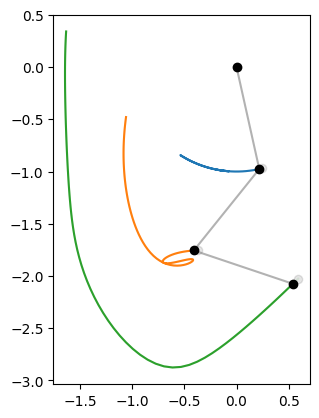

In [37]:
idx = 20

r = trajectories[idx]['actual_pos']

for i in range(r.shape[1]):
    plt.plot(r[:,i,0], r[:,i,1], '-', color=f'C{i}', alpha=0.1)
    
plt.plot([0] + list(r[-1,:,0]), [0] + list(r[-1,:,1]), 'o', color='black', alpha=0.1)
# plt.gca().set_aspect('equal', adjustable='box')
# plt.show()

r = trajectories[idx]['pred_pos']

for i in range(r.shape[1]):
    plt.plot(r[:,i,0], r[:,i,1], '-', color=f'C{i}')
    
plt.plot([0] + list(r[-1,:,0]), [0] + list(r[-1,:,1]), '-', color='gray', alpha=0.6)
plt.plot([0] + list(r[-1,:,0]), [0] + list(r[-1,:,1]), 'o', color='black')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()